Mutual information I(feature; Sd):
FDS_diffusion_term            1.890961
density_ratio_sigma           1.718297
H2O                           1.298378
total_heat_conduction         1.277287
O2_diffusion_total            1.182077
heat_conduction_normal        1.082486
HO2                           1.067433
FDS_diff_velocity_term        1.032048
O2                            1.018817
FDS_src_term                  0.972398
gradT                         0.962340
p                             0.961995
H2                            0.948613
phi_loc                       0.924541
stretch_rate                  0.909817
HRR                           0.908004
H                             0.903834
O                             0.897693
omega_HO2                     0.882495
OH                            0.881403
H2O2                          0.872705
omega_H2O                     0.867757
heat_conduction_tangential    0.866765
omega_H2O2                    0.866191
omega_O2                     

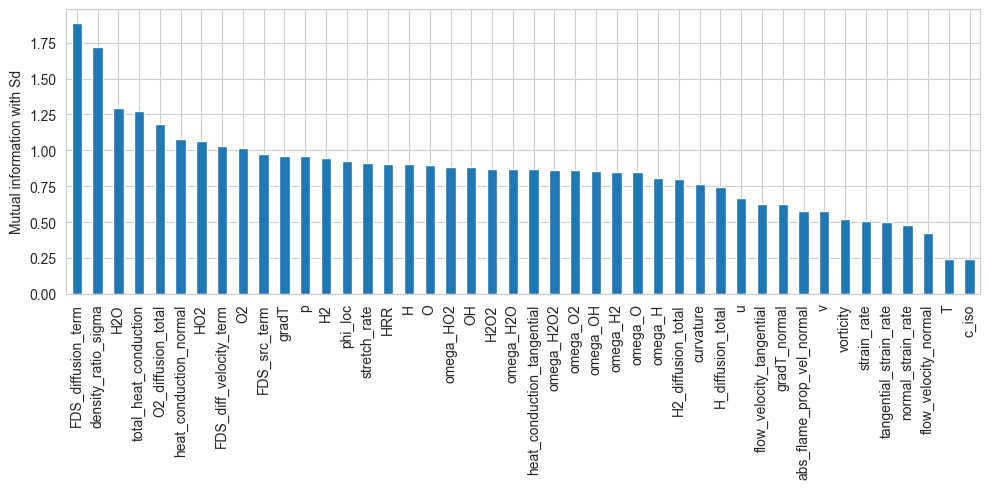

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.feature_selection import mutual_info_regression

time_step = 230
phi = 0.40
lat_size = "200"
T_ref = 300
p_ref = 1e05

isolevels = [3.0, 3.5, 3.8, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7]
n_isolevels = len(isolevels)

multiple_runs = False
n_RUN = 2

Soret_term = False
Soret_positive = False
post = True

dataset = {}
for c_val in isolevels:
    if (Soret_term & Soret_positive):
        save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
    elif Soret_term:
        save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref"
    else:
        save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref"
    if multiple_runs:
        save_name += f"/RUN0{n_RUN}"
    if post:
        save_file_name = f"/extracted_flame_front_post_{time_step}_iso_{c_val}.csv"
    else:
        save_file_name = f"/extracted_flame_front_{time_step}_iso_{c_val}.csv"
    save_name_iso = save_name + save_file_name
    front = pd.read_csv(save_name_iso)
    dataset[c_val] = front

# ============================================================
# CONCATENATE ALL ISOLEVEL FRONTS INTO A SINGLE DATAFRAME
# ============================================================
all_fronts = []
for c_val, front in dataset.items():
    f = front.copy()
    f["c_iso"] = c_val  # keep track of which isolevel each row came from
    all_fronts.append(f)

df_all = pd.concat(all_fronts, ignore_index=True)

# ============================================================
# DEFINE TARGET AND FEATURE SET
# ============================================================
# Adjust this to your actual Sd column name
target_var = "DW_FDS"   # e.g. your Sd-like quantity

# Drop columns you do NOT want as features
cols_to_exclude = ["x", "y", target_var, "z", "N2", "omega_N2"]  # add "c_iso" here if you don't want it as a feature

feature_cols = [c for c in df_all.columns if c not in cols_to_exclude]

# Drop rows with NaNs in either features or target
df_clean = df_all.dropna(subset=feature_cols + [target_var])

X = df_clean[feature_cols].to_numpy()
y = df_clean[target_var].to_numpy()

# ============================================================
# COMPUTE MUTUAL INFORMATION
# ============================================================
mi = mutual_info_regression(X, y, random_state=0)

mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
print("Mutual information I(feature; Sd):")
print(mi_series)

# ============================================================
# SIMPLE BAR PLOT OF MI (OPTIONAL)
# ============================================================
plt.figure(figsize=(10, 5))
mi_series.plot(kind="bar")
plt.ylabel("Mutual information with Sd")
plt.tight_layout()
plt.show()


In [5]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# TARGET AND FEATURE SETUP
# ============================================================
target_var = "DW_FDS"   # <-- your Sd-like target

# Columns you do NOT want to use as features
cols_to_exclude = ["x", "y", target_var, "z", "N2", "omega_N2"]  # optionally add "c_iso" here

feature_cols = [c for c in df_all.columns if c not in cols_to_exclude]

# Clean NaNs
df_clean = df_all.dropna(subset=feature_cols + [target_var])

X = df_clean[feature_cols].to_numpy()
y = df_clean[target_var].to_numpy()

n_samples, n_features = X.shape
print(f"Using {n_samples} samples and {n_features} candidate features.")
print("Features:", feature_cols)

# ============================================================
# 1. MUTUAL INFORMATION: feature ↔ target (RELEVANCE)
# ============================================================
mi_ft = mutual_info_regression(X, y, random_state=0)  # I(X_i ; DW_FDS)
mi_ft_series = pd.Series(mi_ft, index=feature_cols).sort_values(ascending=False)

print("\nMutual information I(feature; DW_FDS):")
print(mi_ft_series)

# ============================================================
# 2. MUTUAL INFORMATION: feature ↔ feature (REDUNDANCY)
#    We precompute a symmetric MI matrix.
# ============================================================
mi_ff = np.zeros((n_features, n_features))

for i in range(n_features):
    Xi = X[:, [i]]  # 2D
    for j in range(i + 1, n_features):
        Xj = X[:, j]  # 1D
        # mutual_info_regression expects X as 2D, y as 1D
        mi_ij = mutual_info_regression(Xi, Xj, random_state=0)[0]
        mi_ff[i, j] = mi_ij
        mi_ff[j, i] = mi_ij

# ============================================================
# 3. GREEDY mRMR SELECTION
#    - maximize relevance I(X_i; y)
#    - minimize redundancy I(X_i; X_j) with already selected
# ============================================================
k_select = min(10, n_features)  # how many features to select (adjust as you like)

selected_indices = []
selected_features = []

for step in range(k_select):
    best_score = -np.inf
    best_j = None

    for j in range(n_features):
        if j in selected_indices:
            continue

        relevance = mi_ft[j]

        if len(selected_indices) == 0:
            redundancy = 0.0
        else:
            # average MI with already selected features
            redundancy = np.mean([mi_ff[j, s] for s in selected_indices])

        score = relevance - redundancy  # mRMR objective

        if score > best_score:
            best_score = score
            best_j = j

    selected_indices.append(best_j)
    selected_features.append(feature_cols[best_j])
    print(f"Step {step+1}: selected {feature_cols[best_j]} "
          f"(mRMR score={best_score:.4f}, relevance={mi_ft[best_j]:.4f})")

print("\nSelected features (mRMR order):")
print(selected_features)

# ============================================================
# 4. OPTIONAL: BAR PLOT OF RELEVANCE (MI WITH DW_FDS)
#    Highlighting selected features
# ============================================================
mi_sorted = mi_ft_series  # already sorted
plt.figure(figsize=(10, 5))
mi_sorted.plot(kind="bar")
plt.ylabel("Mutual information with DW_FDS")
plt.title("Feature relevance (I(feature; DW_FDS))")
plt.tight_layout()
plt.show()


Using 133019 samples and 44 candidate features.
Features: ['v', 'T', 'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'HRR', 'curvature', 'stretch_rate', 'abs_flame_prop_vel_normal', 'flow_velocity_normal', 'flow_velocity_tangential', 'strain_rate', 'tangential_strain_rate', 'normal_strain_rate', 'density_ratio_sigma', 'gradT', 'gradT_normal', 'total_heat_conduction', 'heat_conduction_normal', 'heat_conduction_tangential', 'FDS_src_term', 'FDS_diffusion_term', 'FDS_diff_velocity_term', 'H2_diffusion_total', 'O2_diffusion_total', 'H_diffusion_total', 'vorticity', 'p', 'phi_loc', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH', 'omega_HO2', 'omega_H2O2', 'u', 'c_iso']

Mutual information I(feature; DW_FDS):
FDS_diffusion_term            1.890961
density_ratio_sigma           1.718297
H2O                           1.298378
total_heat_conduction         1.277287
O2_diffusion_total            1.182077
heat_conduction_normal        1.082486
HO2                         

KeyboardInterrupt: 

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# -----------------------------------------
# 0) Ensure curvature exists
# -----------------------------------------
if "curvature" not in df_clean.columns:
    raise ValueError("Column 'curvature' not found in df_clean. "
                     "Adjust the column name accordingly.")

# Re-define X, y from the CLEAN dataframe (for safety)
y = df_clean[target_var].to_numpy()
X_curv = df_clean[["curvature"]].to_numpy()
X_imp  = df_clean[selected_features].to_numpy()

# Total variance of DW_FDS (for normalization)
total_var = np.var(y, ddof=1)
print(f"\nTotal variance of {target_var}: {total_var:.6e}")

# -----------------------------------------
# 1) Train/test split
# -----------------------------------------
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_curv, y, test_size=0.2, random_state=0
)
Xi_train, Xi_test, yi_train, yi_test = train_test_split(
    X_imp,  y, test_size=0.2, random_state=0
)

# -----------------------------------------
# 2) Model using ONLY curvature
# -----------------------------------------
rf_curv = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=0,
    n_jobs=-1,
)
rf_curv.fit(Xc_train, yc_train)

y_pred_curv = rf_curv.predict(Xc_test)
res_curv = yi_test - y_pred_curv  # yi_test and yc_test are same split, same random_state

res_var_curv = np.var(res_curv, ddof=1)
R2_curv = 1.0 - res_var_curv / total_var

print("\n=== Model with curvature only ===")
print(f"Residual variance (test): {res_var_curv:.6e}")
print(f"Explained variance ratio R^2 (vs total var): {R2_curv:.4f}")

# -----------------------------------------
# 3) Model using ALL SELECTED FEATURES
# -----------------------------------------
rf_imp = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=0,
    n_jobs=-1,
)
rf_imp.fit(Xi_train, yi_train)

y_pred_imp = rf_imp.predict(Xi_test)
res_imp = yi_test - y_pred_imp

res_var_imp = np.var(res_imp, ddof=1)
R2_imp = 1.0 - res_var_imp / total_var

print("\n=== Model with mRMR-selected features ===")
print(f"Residual variance (test): {res_var_imp:.6e}")
print(f"Explained variance ratio R^2 (vs total var): {R2_imp:.4f}")

# -----------------------------------------
# 4) Optional: ratio of residual variances
# -----------------------------------------
if res_var_curv > 0:
    improvement = 1.0 - res_var_imp / res_var_curv
    print(f"\nRelative reduction of residual variance vs curvature-only: {improvement*100:.2f}%")



Total variance of DW_FDS: 3.867972e-01

=== Model with curvature only ===
Residual variance (test): 4.150684e-01
Explained variance ratio R^2 (vs total var): -0.0731

=== Model with mRMR-selected features ===
Residual variance (test): 2.195116e-03
Explained variance ratio R^2 (vs total var): 0.9943

Relative reduction of residual variance vs curvature-only: 99.47%



=== Global variance comparison (full df_clean) ===
Total var(DW_FDS)        : 3.867972e-01
Var(residual, curvature) : 1.302153e-01
Var(residual, mRMR set)  : 5.577204e-04
R^2 curvature only       : 0.6634
R^2 mRMR features        : 0.9986


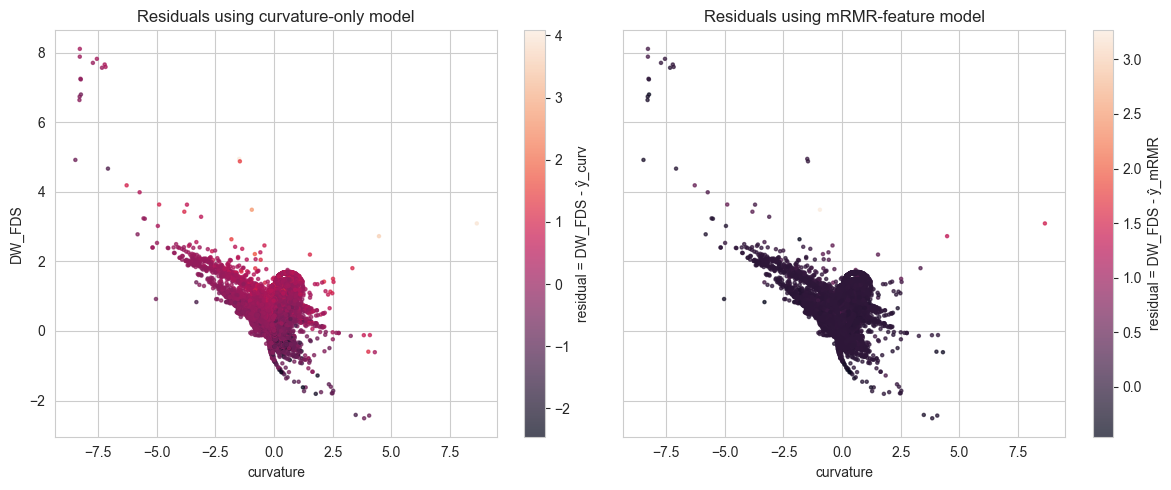

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1) PREDICTIONS ON THE WHOLE CLEAN DATASET
# ============================================================
y_true = df_clean[target_var].to_numpy()
curv   = df_clean["curvature"].to_numpy().reshape(-1, 1)

X_imp_all = df_clean[selected_features].to_numpy()

# Predictions
y_pred_curv_all = rf_curv.predict(curv)          # model that sees ONLY curvature
y_pred_imp_all  = rf_imp.predict(X_imp_all)      # model that sees ALL selected features

# Residuals
res_curv_all = y_true - y_pred_curv_all
res_imp_all  = y_true - y_pred_imp_all

# Variances (over the whole dataset this time)
res_var_curv_all = np.var(res_curv_all, ddof=1)
res_var_imp_all  = np.var(res_imp_all, ddof=1)
total_var_all    = np.var(y_true, ddof=1)

print("\n=== Global variance comparison (full df_clean) ===")
print(f"Total var(DW_FDS)        : {total_var_all:.6e}")
print(f"Var(residual, curvature) : {res_var_curv_all:.6e}")
print(f"Var(residual, mRMR set)  : {res_var_imp_all:.6e}")
print(f"R^2 curvature only       : {1 - res_var_curv_all/total_var_all:.4f}")
print(f"R^2 mRMR features        : {1 - res_var_imp_all/total_var_all:.4f}")

# ============================================================
# 2) SCATTER PLOTS: DW_FDS vs curvature
#    coloured by residuals of each model
# ============================================================

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sc0 = axs[0].scatter(
    curv.flatten(), y_true,
    c=res_curv_all, s=5, alpha=0.7,
)
axs[0].set_xlabel("curvature")
axs[0].set_ylabel("DW_FDS")
axs[0].set_title("Residuals using curvature-only model")
cb0 = plt.colorbar(sc0, ax=axs[0])
cb0.set_label("residual = DW_FDS - ŷ_curv")

sc1 = axs[1].scatter(
    curv.flatten(), y_true,
    c=res_imp_all, s=5, alpha=0.7
)
axs[1].set_xlabel("curvature")
axs[1].set_title("Residuals using mRMR-feature model")
cb1 = plt.colorbar(sc1, ax=axs[1])
cb1.set_label("residual = DW_FDS - ŷ_mRMR")

plt.tight_layout()
plt.show()


Threshold for large |residual| (q=0.8): 3.900782e-01
Number of big-residual points: 10715 / 53573


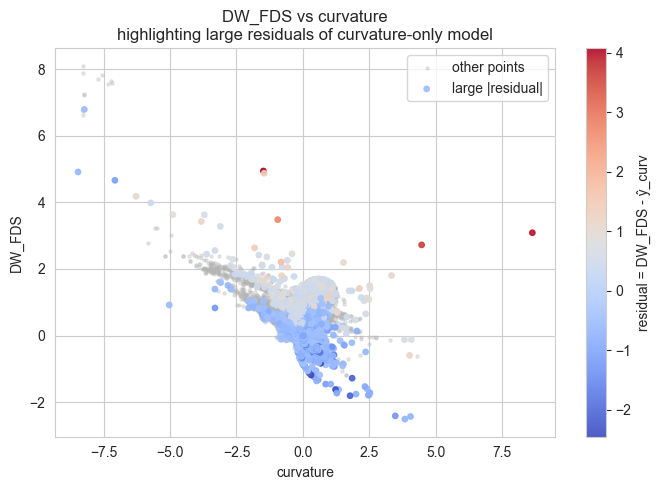

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 1) Recompute predictions and residuals
# ============================================
y_true = df_clean[target_var].to_numpy()
curv   = df_clean["curvature"].to_numpy().reshape(-1, 1)

y_pred_curv_all = rf_curv.predict(curv)
res_curv_all = y_true - y_pred_curv_all
abs_res = np.abs(res_curv_all)

# ============================================
# 2) Define "large residual" threshold (top 5%)
# ============================================
quantile = 0.80  # adjust if you want more/less strict
thr = np.quantile(abs_res, quantile)
mask_big = abs_res >= thr

print(f"Threshold for large |residual| (q={quantile}): {thr:.6e}")
print(f"Number of big-residual points: {mask_big.sum()} / {len(mask_big)}")

# ============================================
# 3) Scatter plot Sd vs curvature
#    highlight big-residual points
# ============================================
fig, ax = plt.subplots(figsize=(7, 5))

# All points (small, grey)
ax.scatter(
    curv[~mask_big].flatten(),
    y_true[~mask_big],
    s=5,
    alpha=0.3,
    color="0.7",
    label="other points",
)

# Big-residual points (colour)
sc = ax.scatter(
    curv[mask_big].flatten(),
    y_true[mask_big],
    s=15,
    alpha=0.9,
    c=res_curv_all[mask_big],
    cmap="coolwarm",
    label="large |residual|",
)

ax.set_xlabel("curvature")
ax.set_ylabel(target_var)
ax.set_title(f"{target_var} vs curvature\nhighlighting large residuals of curvature-only model")

cb = plt.colorbar(sc, ax=ax)
cb.set_label("residual = DW_FDS - ŷ_curv")

ax.legend()
plt.tight_layout()
plt.show()


Total variance of DW_FDS: 3.867972e-01

=== Model with curvature + stretch_rate ===
Residual variance (test): 8.800372e-02
R^2 (vs total var): 0.7725

=== Comparison to curvature-only model ===
Residual var (curvature only): 4.150684e-01 (R^2 = -0.0731)
Relative reduction of residual variance (curv+stretch vs curv): 78.80%


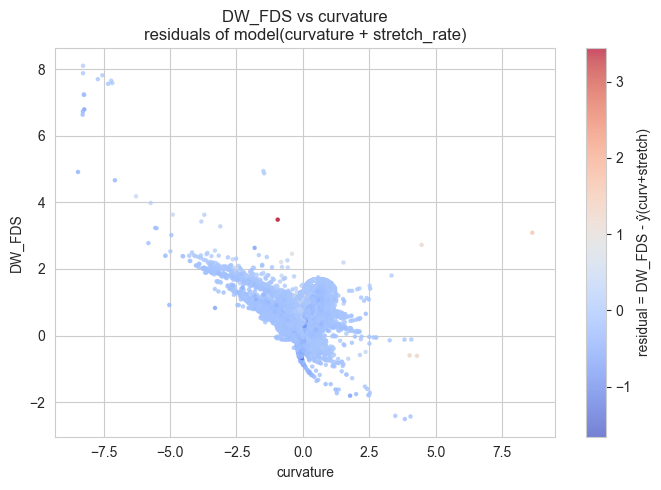

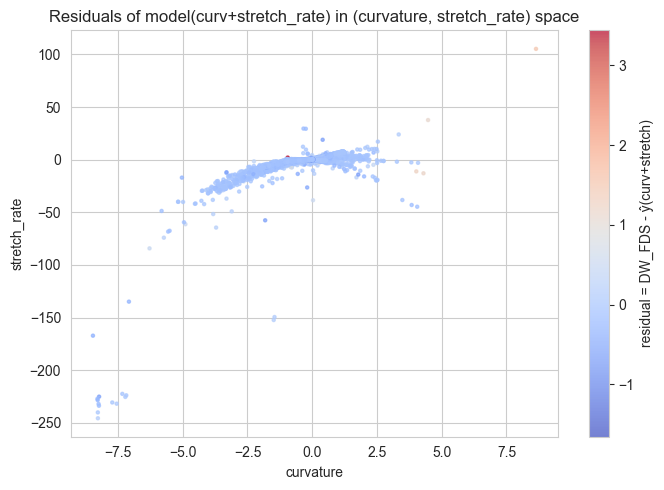

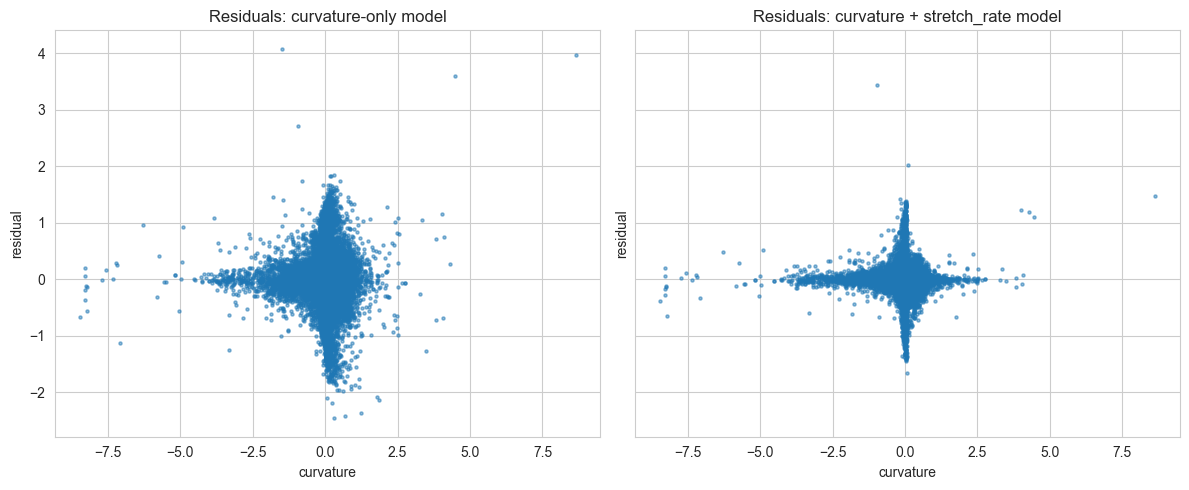

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 0) Safety checks
# ===============================
for col in ["curvature", "stretch_rate"]:
    if col not in df_clean.columns:
        raise ValueError(f"Column '{col}' not found in df_clean.")

y = df_clean[target_var].to_numpy()
curv = df_clean["curvature"].to_numpy().reshape(-1, 1)
X_cs = df_clean[["curvature", "stretch_rate"]].to_numpy()

total_var = np.var(y, ddof=1)
print(f"Total variance of {target_var}: {total_var:.6e}")

# ===============================
# 1) Train/test split
# ===============================
Xcs_train, Xcs_test, ycs_train, ycs_test = train_test_split(
    X_cs, y, test_size=0.2, random_state=0
)

rf_cs = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=0,
    n_jobs=-1,
)
rf_cs.fit(Xcs_train, ycs_train)

y_pred_cs = rf_cs.predict(Xcs_test)
res_cs = ycs_test - y_pred_cs
res_var_cs = np.var(res_cs, ddof=1)
R2_cs = 1.0 - res_var_cs / total_var

print("\n=== Model with curvature + stretch_rate ===")
print(f"Residual variance (test): {res_var_cs:.6e}")
print(f"R^2 (vs total var): {R2_cs:.4f}")

# ===============================
# 2) Compare vs curvature-only (if rf_curv exists)
# ===============================
try:
    y_pred_curv_test = rf_curv.predict(Xcs_test[:, [0]])  # first col = curvature
    res_curv_test = ycs_test - y_pred_curv_test
    res_var_curv = np.var(res_curv_test, ddof=1)
    R2_curv = 1.0 - res_var_curv / total_var

    print("\n=== Comparison to curvature-only model ===")
    print(f"Residual var (curvature only): {res_var_curv:.6e} (R^2 = {R2_curv:.4f})")
    if res_var_curv > 0:
        improvement = 1.0 - res_var_cs / res_var_curv
        print(f"Relative reduction of residual variance (curv+stretch vs curv): "
              f"{improvement*100:.2f}%")
except NameError:
    print("\nrf_curv not defined in this session; skipping curvature-only comparison.")

# ===============================
# 3) Residuals on FULL dataset
# ===============================
y_pred_cs_all = rf_cs.predict(X_cs)
res_cs_all = y - y_pred_cs_all

# for comparison, curvature-only residuals on full dataset (if available)
try:
    y_pred_curv_all = rf_curv.predict(curv)
    res_curv_all = y - y_pred_curv_all
except NameError:
    y_pred_curv_all = None
    res_curv_all = None

# ===============================
# 4) Plots
# ===============================

# (a) Sd vs curvature coloured by residual (curv+stretch model)
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(
    df_clean["curvature"].to_numpy(),
    y,
    c=res_cs_all,
    s=5,
    alpha=0.7,
    cmap="coolwarm",
)
ax.set_xlabel("curvature")
ax.set_ylabel(target_var)
ax.set_title(f"{target_var} vs curvature\nresiduals of model(curvature + stretch_rate)")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("residual = DW_FDS - ŷ(curv+stretch)")
plt.tight_layout()
plt.show()

# (b) Residuals in (curvature, stretch_rate) space
fig, ax = plt.subplots(figsize=(7, 5))
sc2 = ax.scatter(
    df_clean["curvature"].to_numpy(),
    df_clean["stretch_rate"].to_numpy(),
    c=res_cs_all,
    s=5,
    alpha=0.7,
    cmap="coolwarm",
)
ax.set_xlabel("curvature")
ax.set_ylabel("stretch_rate")
ax.set_title("Residuals of model(curv+stretch_rate) in (curvature, stretch_rate) space")
cb2 = plt.colorbar(sc2, ax=ax)
cb2.set_label("residual = DW_FDS - ŷ(curv+stretch)")
plt.tight_layout()
plt.show()

# (c) Optional: compare curvature-only vs curv+stretch residuals wrt curvature
if res_curv_all is not None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    sc0 = axs[0].scatter(
        df_clean["curvature"].to_numpy(),
        res_curv_all,
        s=5,
        alpha=0.5,
    )
    axs[0].set_xlabel("curvature")
    axs[0].set_ylabel("residual")
    axs[0].set_title("Residuals: curvature-only model")

    sc1 = axs[1].scatter(
        df_clean["curvature"].to_numpy(),
        res_cs_all,
        s=5,
        alpha=0.5,
    )
    axs[1].set_xlabel("curvature")
    axs[1].set_ylabel("residual")
    axs[1].set_title("Residuals: curvature + stretch_rate model")

    plt.tight_layout()
    plt.show()


Total variance of DW_FDS: 3.867972e-01

Training MLP: curvature only...
Training MLP: curvature + stretch_rate...
Training MLP: selected features...

=== MLP: curvature only ===
Residual variance (test): 2.967220e-01
R^2 vs total var(DW_FDS): 0.2329

=== MLP: curvature + stretch_rate ===
Residual variance (test): 2.774223e-02
R^2 vs total var(DW_FDS): 0.9283

=== MLP: selected features (mRMR) ===
Residual variance (test): 1.284561e-03
R^2 vs total var(DW_FDS): 0.9967

Relative reduction (curv+stretch vs curv): 90.65%
Relative reduction (selected vs curv):      99.57%


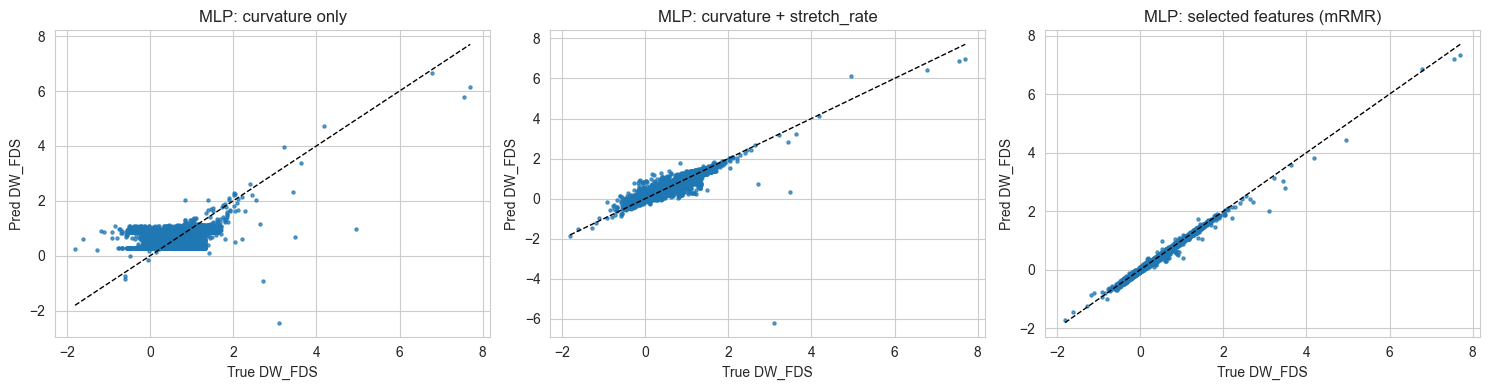

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0) Basic setup
# ============================================================
target_var = "DW_FDS"

for col in ["curvature", "stretch_rate"]:
    if col not in df_clean.columns:
        raise ValueError(f"Column '{col}' not found in df_clean.")

y = df_clean[target_var].to_numpy()

X_curv = df_clean[["curvature"]].to_numpy()
X_cs   = df_clean[["curvature", "stretch_rate", "density_ratio_sigma"]].to_numpy()
X_sel  = df_clean[selected_features].to_numpy()

total_var = np.var(y, ddof=1)
print(f"Total variance of {target_var}: {total_var:.6e}")

# ============================================================
# 1) Use a single train/test split (same indices for all inputs)
# ============================================================
n_samples = len(y)
indices = np.arange(n_samples)

idx_train, idx_test = train_test_split(
    indices, test_size=0.2, random_state=0, shuffle=True
)

def split_and_scale(X, y, idx_train, idx_test):
    """Helper: split and scale features."""
    X_train = X[idx_train]
    X_test  = X[idx_test]
    y_train = y[idx_train]
    y_test  = y[idx_test]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# prepare datasets
Xc_tr, Xc_te, yc_tr, yc_te, scaler_c   = split_and_scale(X_curv, y, indices, indices)  # dummy, just for shape
Xc_tr, Xc_te, yc_tr, yc_te, scaler_c   = split_and_scale(X_curv, y, idx_train, idx_test)
Xcs_tr, Xcs_te, ycs_tr, ycs_te, scaler_cs = split_and_scale(X_cs,   y, idx_train, idx_test)
Xs_tr, Xs_te, ys_tr, ys_te, scaler_s   = split_and_scale(X_sel,  y, idx_train, idx_test)

# ============================================================
# 2) Define a small MLP architecture
# ============================================================
def make_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(64, 64),  # small network
        activation="relu",
        solver="adam",
        alpha=1e-3,          # L2 regularization
        batch_size="auto",
        learning_rate="adaptive",
        max_iter=500,
        random_state=0,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
    )

mlp_curv = make_mlp()
mlp_cs   = make_mlp()
mlp_sel  = make_mlp()

# ============================================================
# 3) Train the three MLPs
# ============================================================
print("\nTraining MLP: curvature only...")
mlp_curv.fit(Xc_tr, yc_tr)

print("Training MLP: curvature + stretch_rate...")
mlp_cs.fit(Xcs_tr, ycs_tr)

print("Training MLP: selected features...")
mlp_sel.fit(Xs_tr, ys_tr)

# ============================================================
# 4) Evaluate: residual variance and R^2 on test set
# ============================================================
def eval_model(name, model, X_te, y_te):
    y_pred = model.predict(X_te)
    res = y_te - y_pred
    res_var = np.var(res, ddof=1)
    R2 = 1.0 - res_var / total_var
    print(f"\n=== {name} ===")
    print(f"Residual variance (test): {res_var:.6e}")
    print(f"R^2 vs total var(DW_FDS): {R2:.4f}")
    return res_var, R2, y_pred

res_var_c,  R2_c,  ypred_c  = eval_model("MLP: curvature only",             mlp_curv, Xc_te,  yc_te)
res_var_cs, R2_cs, ypred_cs = eval_model("MLP: curvature + stretch_rate",   mlp_cs,   Xcs_te, ycs_te)
res_var_s,  R2_s,  ypred_s  = eval_model("MLP: selected features (mRMR)",   mlp_sel,  Xs_te,  ys_te)

# Optionally compare relative improvements
if res_var_c > 0:
    print(f"\nRelative reduction (curv+stretch vs curv): {(1 - res_var_cs/res_var_c)*100:.2f}%")
    print(f"Relative reduction (selected vs curv):      {(1 - res_var_s/res_var_c)*100:.2f}%")

# ============================================================
# 5) Optional: scatter plots (test set)
# ============================================================
# Map test indices back to physical values for plotting
curv_test = X_curv[idx_test, 0]
stretch_test = X_cs[idx_test, 1]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# (a) curvature only: true vs pred
axs[0].scatter(yc_te, ypred_c, s=5, alpha=0.7)
axs[0].plot([yc_te.min(), yc_te.max()], [yc_te.min(), yc_te.max()], "k--", lw=1)
axs[0].set_xlabel("True DW_FDS")
axs[0].set_ylabel("Pred DW_FDS")
axs[0].set_title("MLP: curvature only")

# (b) curvature + stretch
axs[1].scatter(ycs_te, ypred_cs, s=5, alpha=0.7)
axs[1].plot([ycs_te.min(), ycs_te.max()], [ycs_te.min(), ycs_te.max()], "k--", lw=1)
axs[1].set_xlabel("True DW_FDS")
axs[1].set_ylabel("Pred DW_FDS")
axs[1].set_title("MLP: curvature + stretch_rate")

# (c) selected features
axs[2].scatter(ys_te, ypred_s, s=5, alpha=0.7)
axs[2].plot([ys_te.min(), ys_te.max()], [ys_te.min(), ys_te.max()], "k--", lw=1)
axs[2].set_xlabel("True DW_FDS")
axs[2].set_ylabel("Pred DW_FDS")
axs[2].set_title("MLP: selected features (mRMR)")

plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import plotly.graph_objects as go

# ============================================================
# 1) Collect data and predictions from the MLP(curv + stretch)
# ============================================================
target_var = "DW_FDS"

curv_vals  = df_clean["curvature"].to_numpy()
stre_vals  = df_clean["stretch_rate"].to_numpy()
y_true     = df_clean[target_var].to_numpy()

# Build feature matrix and scale it with the SAME scaler used in training
X_cs_all       = np.column_stack([curv_vals, stre_vals])
X_cs_all_scaled = scaler_cs.transform(X_cs_all)

y_pred_all = mlp_cs.predict(X_cs_all_scaled)
residuals  = y_true - y_pred_all

# For colouring: symmetric limits around 0
abs_max_res = np.max(np.abs(residuals))

# ============================================================
# 2) Build a grid in (curvature, stretch_rate) space
#    and evaluate the MLP on that grid to get the surface
# ============================================================
# Use central 1–99% range to avoid extreme outliers
curv_min, curv_max = np.percentile(curv_vals, [1, 99])
stre_min, stre_max = np.percentile(stre_vals, [1, 99])

n_grid = 50  # resolution of the surface

curv_lin = np.linspace(curv_min, curv_max, n_grid)
stre_lin = np.linspace(stre_min, stre_max, n_grid)

C_grid, S_grid = np.meshgrid(curv_lin, stre_lin)
X_grid = np.column_stack([C_grid.ravel(), S_grid.ravel()])
X_grid_scaled = scaler_cs.transform(X_grid)

Z_pred = mlp_cs.predict(X_grid_scaled).reshape(C_grid.shape)

# ============================================================
# 3) Build Plotly 3D figure: surface + scatter
# ============================================================
fig = go.Figure()

# --- fitted surface S_d_hat(curv, stretch) ---
fig.add_trace(
    go.Surface(
        x=C_grid,
        y=S_grid,
        z=Z_pred,
        colorscale="Viridis",
        opacity=0.7,
        showscale=False,
        name="MLP surface",
    )
)

# --- data points coloured by residual ---
fig.add_trace(
    go.Scatter3d(
        x=curv_vals,
        y=stre_vals,
        z=y_true,
        mode="markers",
        marker=dict(
            size=4,
            color=residuals,
            colorscale="RdBu",
            cmin=-abs_max_res,
            cmax= abs_max_res,
            colorbar=dict(
                title="residual = S_true - S_pred",
            ),
        ),
        name="DNS points",
        hovertemplate=(
            "curvature=%{x:.4e}<br>"
            "stretch_rate=%{y:.4e}<br>"
            f"{target_var} (true)=%{{z:.4e}}<br>"
            f"{target_var} (pred)=%{{customdata[0]:.4e}}<br>"
            "residual=%{marker.color:.4e}"
            "<extra></extra>"
        ),
        customdata=np.column_stack([y_pred_all]),
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title="curvature",
        yaxis_title="stretch_rate",
        zaxis_title=target_var,
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, t=40, b=0),
    title="MLP fit: DW_FDS(curvature, stretch_rate) with residuals",
)

fig.show()


In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.graph_objects as go

# ============================================================
# 1) Prepare data: curvature, stretch_rate, density_ratio_sigma
# ============================================================
target_var = "DW_FDS"

for col in ["curvature", "stretch_rate", "density_ratio_sigma"]:
    if col not in df_clean.columns:
        raise ValueError(f"Column '{col}' not found in df_clean.")

curv_vals  = df_clean["curvature"].to_numpy()
stre_vals  = df_clean["stretch_rate"].to_numpy()
dens_vals  = df_clean["density_ratio_sigma"].to_numpy()
y_true     = df_clean[target_var].to_numpy()

X_csd = np.column_stack([curv_vals, stre_vals, dens_vals])

# train/test split for a quick check of generalization
X_train, X_test, y_train, y_test = train_test_split(
    X_csd, y_true, test_size=0.2, random_state=0, shuffle=True
)

# scale inputs
scaler_csd = StandardScaler()
X_train_scaled = scaler_csd.fit_transform(X_train)
X_test_scaled  = scaler_csd.transform(X_test)

# ============================================================
# 2) Define and train a small MLP
# ============================================================
mlp_csd = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate="adaptive",
    max_iter=500,
    random_state=0,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
)

print("Training MLP with [curvature, stretch_rate, density_ratio_sigma]...")
mlp_csd.fit(X_train_scaled, y_train)

# quick test metrics
y_test_pred = mlp_csd.predict(X_test_scaled)
res_test = y_test - y_test_pred
res_var_test = np.var(res_test, ddof=1)
total_var = np.var(y_true, ddof=1)
R2_test = 1.0 - res_var_test / total_var
print(f"Test residual variance: {res_var_test:.6e}")
print(f"Test R^2 vs total var(DW_FDS): {R2_test:.4f}")

# ============================================================
# 3) Predictions and residuals on the FULL dataset
# ============================================================
X_csd_scaled_all = scaler_csd.transform(X_csd)
y_pred_all = mlp_csd.predict(X_csd_scaled_all)
residuals  = y_true - y_pred_all   # deviation from true DW_FDS

abs_max_res = np.max(np.abs(residuals))
print(f"Max |residual| (full data): {abs_max_res:.6e}")

# ============================================================
# 4) 3D interactive Plotly plot:
#    axes: (curvature, stretch_rate, density_ratio_sigma)
#    colour: error from true DW_FDS
# ============================================================
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=curv_vals,
        y=stre_vals,
        z=dens_vals,
        mode="markers",
        marker=dict(
            size=4,
            color=residuals,
            colorscale="RdBu",
            cmin=-abs_max_res,
            cmax= abs_max_res,
            colorbar=dict(
                title="residual = DW_FDS_true - DW_FDS_pred",
            ),
        ),
        name="DNS points",
        hovertemplate=(
            "curvature=%{x:.4e}<br>"
            "stretch_rate=%{y:.4e}<br>"
            "density_ratio_sigma=%{z:.4e}<br>"
            f"{target_var} (true)=%{{customdata[0]:.4e}}<br>"
            f"{target_var} (pred)=%{{customdata[1]:.4e}}<br>"
            "residual=%{marker.color:.4e}"
            "<extra></extra>"
        ),
        customdata=np.column_stack([y_true, y_pred_all]),
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title="curvature",
        yaxis_title="stretch_rate",
        zaxis_title="density_ratio_sigma",
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, t=40, b=0),
    title="MLP fit: DW_FDS(curvature, stretch_rate, density_ratio_sigma) – residual colouring",
)

fig.show()


NameError: name 'df_clean' is not defined